In [12]:
!pip install boruta
!pip install shap
!pip install imblearn

In [13]:
import pandas as pd
import numpy as np
import sklearn
from numpy import float16, mean, std
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    KFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    train_test_split,
)
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
import random
random.seed(42)  # Set the random seed to 42 for reproducibility

In [15]:
# Load Dataset
file_path = "/Users/Sebastiano/ML_MRI copy.xlsx"
df = pd.read_excel(file_path)

df = shuffle(df)
df.reset_index(inplace=True, drop=True)
print("N° of patients: {}".format(len(df)))
print("N° of columns: {}".format(df.shape[1]))
df.head()

N° of patients: 47
N° of columns: 932


,Patient,Gender,Age,NP-SLE,Event,Scale factor,SNR,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,paziente 31,0,48,1,Psychosis,0.75214,45.3995,457.9349,34.1854,456.3373,...,2.0690,0.018769,3.17310,1.9140,0.017363,2.0025,0.018165,1.8525,0.016805,7.7805
1,Paziente 11,0,32,0,Na,0.68846,51.0280,481.9302,38.3537,481.5288,...,3.3313,0.030871,6.72540,2.0754,0.019233,2.0308,0.018820,2.1096,0.019550,-3.8050
2,Paziente 8,0,54,1,CVA,0.71120,96.0198,456.0017,36.1367,450.6699,...,1.0781,0.009976,50.68130,1.4518,0.013435,1.5331,0.014188,1.3756,0.012729,10.8339
3,job1628629,1,54,2,Na,0.81971,32.0438,462.7571,32.7784,454.7329,...,3.3826,0.030153,0.30447,2.3141,0.020628,2.3538,0.020982,2.2833,0.020354,3.0395
4,Paziente 10,1,53,1,Seizure,0.90248,34.1831,652.3232,40.5777,649.4136,...,2.9130,0.024867,7.83990,2.2472,0.019183,2.3174,0.019782,2.1936,0.018726,5.4860


In [16]:
# Drop unwanted columns

df = df.drop(['Patient', 'Gender', 'Age','Event', 'Scale factor', 'SNR'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 925 


In [17]:
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = df.columns.difference(['NP-SLE']) 

# Normalize the selected features
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

## Random Forest

In [18]:
def train_test(data: pd.DataFrame):
    
    """Return train-test subjects"""

    np_patients = df.loc[df['NP-SLE'] == 1]
    nonp_patients = df.loc[df['NP-SLE'] == 0]
    hc_patients = df.loc[df['NP-SLE'] == 2]


    print(f"number of neuro patients: {len(np_patients)}")
    print(f"number of non neuro patients: {len(nonp_patients)}")
    print(f"number of non neuro patients: {len(hc_patients)}")


    number_of_train_nonp = math.floor(0.8 * len(nonp_patients))  # = 
    number_of_train_np = math.floor(0.8 * len(np_patients))
    number_of_train_hc = math.floor(0.8 * len(hc_patients))  # = 
    train_nonp = nonp_patients[:number_of_train_nonp]
    train_np = np_patients[:number_of_train_np]
    train_hc = hc_patients[:number_of_train_hc]

    test_nonp = nonp_patients[number_of_train_nonp:]
    test_np = np_patients[number_of_train_np:]
    test_hc = hc_patients[number_of_train_hc:]

    assert len(train_nonp) + len(test_nonp) == len(nonp_patients)
    assert len(train_np) + len(test_np) == len(np_patients)
    assert len(train_hc) + len(test_hc) == len(hc_patients)

    train = pd.concat([train_np, train_nonp, train_hc])
    test = pd.concat([test_np, test_nonp, test_hc])

    return train, test

In [19]:
train, test = train_test(df)
X_train = train.loc[:,:]
X_test = test.loc[:,:]
y_train = train.pop("NP-SLE")
y_test = test.pop("NP-SLE")

clf = RandomForestClassifier(n_estimators=500)
# Perform 5-fold cross-validation
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)

# Fit the model on the entire training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Calculate and print accuracy
test_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", test_accuracy)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Accuracy:", cv_scores.mean())

number of neuro patients: 14
number of non neuro patients: 13
number of non neuro patients: 20
Accuracy on Test Set: 0.7
Cross-Validation Scores: [0.625      0.75       0.71428571 0.71428571 0.71428571]
Average Cross-Validation Accuracy: 0.7035714285714286


In [20]:
ConfusionMatrix = metrics.confusion_matrix(y_test, y_pred)
print(ConfusionMatrix)

[[1 2 0]
 [1 2 0]
 [0 0 4]]


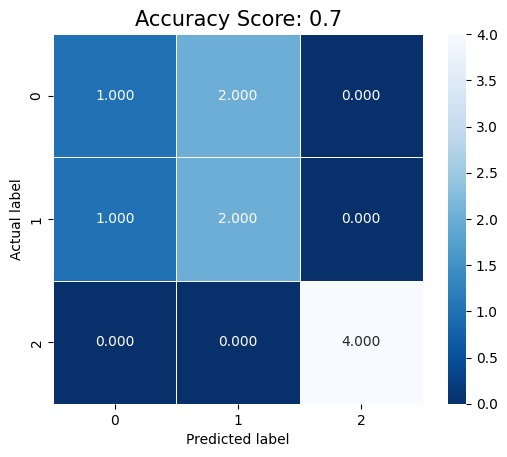

In [21]:
sns.heatmap(ConfusionMatrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);

## RF_2

In [14]:
target = df['NP-SLE']
inputs = df.drop(['NP-SLE'], axis = 'columns')
x_train, x_test, y_train, y_test = train_test_split(inputs,target,test_size=0.20, random_state=10)

In [15]:
from boruta import BorutaPy
np.int = int  # Override np.int with int

x = x_train.values
y = y_train.values
y = y.ravel()

rf_boruta = RandomForestClassifier(n_jobs=-1, class_weight={0: 1, 1: 3}, max_depth=3)
feat_selector = BorutaPy(rf_boruta, n_estimators='auto', verbose=0, random_state=42, perc=0.3)
feat_selector.fit(x, y)

cols = inputs.columns[feat_selector.support_]
print("N° of selected features: {}".format(len(cols)))
print(cols)


N° of selected features: 614
Index(['White Matter (WM) volume cm3', 'White Matter (WM) volume %',
       'Normal Appearing White Matter volume cm3',
       'Normal Appearing White Matter volume %',
       'Abnormal Appearing White Matter volume cm3',
       'Abnormal Appearing White Matter volume %',
       'Grey Matter (GM) volume cm3', 'Grey Matter (GM) volume %',
       'Cortical Grey Matter volume %', 'Cerebellar Grey Matter volume cm3',
       ...
       'PIns right thickness norm.', 'PIns left thickness mm',
       'PIns thickness asymmetry', 'CO left thickness mm',
       'CO thickness asymmetry', 'PO total thickness norm.',
       'PO right thickness mm', 'PO right thickness norm.',
       'PO left thickness mm', 'PO thickness asymmetry'],
      dtype='object', length=614)


In [16]:
from sklearn.utils.class_weight import compute_class_weight

# Define the class weights based on the training data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary of class weights
class_weight = {i: weight for i, weight in enumerate(class_weights)}

print(class_weight)

{0: 1.0277777777777777, 1: 1.3703703703703705, 2: 0.7708333333333334}


In [17]:
from sklearn.model_selection import RandomizedSearchCV

# The function to measure the quality of a split
criterion = ['gini', 'entropy']

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=50, num=5)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(14, 30, num=2)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 8]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 6]

max_leaf_nodes = [None, 2, 3, 4, 5, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {
    'criterion': criterion,
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_leaf_nodes': max_leaf_nodes,
    'bootstrap': bootstrap
}

# First create the base model to tune
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight=class_weight
)

# Random search of parameters, using 5 fold cross validation, different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=500,
    cv=5
)

# Fit the random search model
rf_random.fit(x_train, y_train)
rf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 3,
 'min_samples_leaf': 6,
 'max_leaf_nodes': 5,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'gini',
 'bootstrap': True}

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=20,
                            criterion='gini',
                            n_estimators=50,
                            min_samples_split=3,
                            min_samples_leaf=6,
                            max_leaf_nodes=5,
                            max_features='sqrt',
                            max_depth=30,
                            bootstrap=True)

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

# Perform k-fold cross-validation and calculate the average accuracy
cross_val_scores = cross_val_score(rf, x_train, y_train, cv=stratified_kfold)
average_cross_val_accuracy = cross_val_scores.mean()

# Fit the model on the entire training set and predict on the test set
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

# Calculate accuracy and print a classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

# Output the results
print("Average Cross-Validation Accuracy:", average_cross_val_accuracy)
print("Accuracy on Test Set:", accuracy)
print("Classification Report:\n", report)


Average Cross-Validation Accuracy: 0.725
Accuracy on Test Set: 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.20      1.00      0.33         1
           1       1.00      0.20      0.33         5
           2       1.00      1.00      1.00         4

    accuracy                           0.60        10
   macro avg       0.73      0.73      0.56        10
weighted avg       0.92      0.60      0.60        10



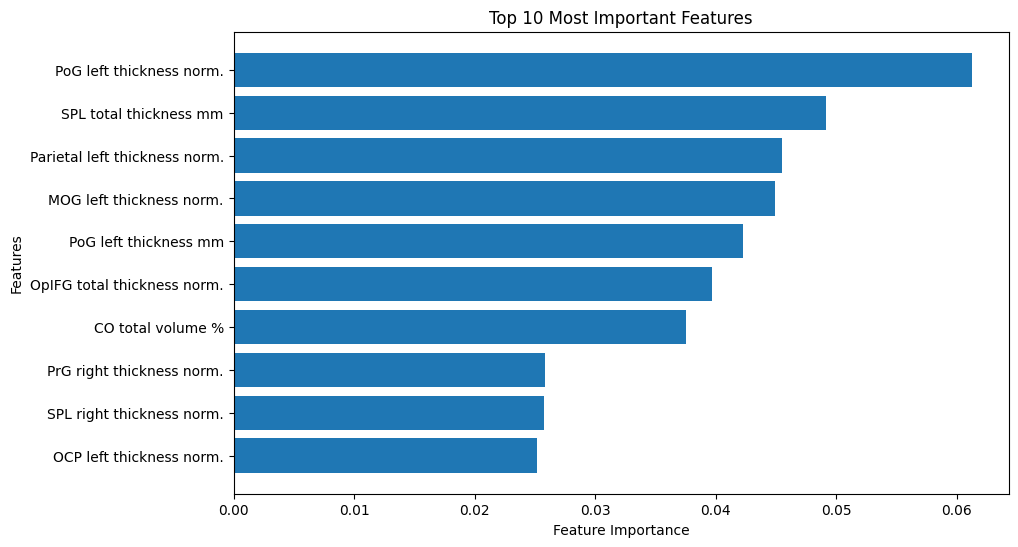

In [22]:
# Get the feature importances
importances = rf.feature_importances_

# Get the indices of the top 10 most important features
top_indices = np.argsort(importances)[-10:]

# Get the names of the top 10 most important features
top_features = inputs.columns[top_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), importances[top_indices], align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features')
plt.show()